# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

%cd /content/drive/MyDrive/Autoencoders
from get_dataset import fetch_dataset
data, attrs = fetch_dataset(dimx=48, dimy=48)

/content/drive/MyDrive/Autoencoders
images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
# with open('data.npy', 'wb') as f:
#     np.save(f, data)

# attrs.to_csv('attrs.csv', index=False, header=True)

%cd /content/drive/MyDrive/Autoencoders
with open('data.npy', 'rb') as f:
    data = np.load(f)
print(data.shape)

attrs = pd.read_csv('attrs.csv', header=0)
print(attrs.shape)

/content/drive/MyDrive/Autoencoders
(13143, 48, 48, 3)
(13143, 73)



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

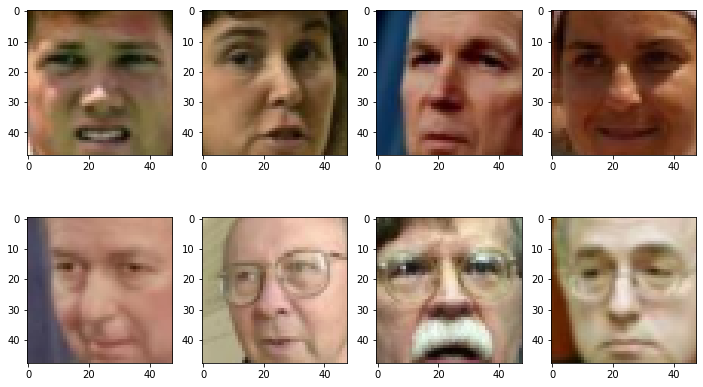

In [ ]:
plt.figure(figsize=(12, 7))
for i, image in enumerate(np.random.choice(data.shape[0], 8)):
    plt.subplot(int('24' + str(i+1)))
    plt.imshow(data[image])

In [ ]:
np.random.seed(42)
train_part, val_part = np.split(np.random.permutation(np.arange(data.shape[0])), [int(data.shape[0] * 0.8)])

X_train, X_val, attrs_train, attrs_val = data[train_part], data[val_part], attrs.iloc[train_part], attrs.iloc[val_part]

X_train_t = torch.from_numpy(np.rollaxis(X_train, 3, 1)).to(torch.float32)
X_val_t = torch.from_numpy(np.rollaxis(X_val, 3, 1)).to(torch.float32)

from torch.utils.data import DataLoader
batch_size = 25
data_train = DataLoader(X_train_t, batch_size=batch_size, shuffle=False)
data_val = DataLoader(X_val_t, batch_size=batch_size, shuffle=False)

## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

^ вот так выглядит автоэнкодер

In [ ]:
dim_code = 288 # выберите размер латентного вектора, т.е. code, самой "узкой" части автоэнкодера

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder>
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
            ) # 48
        self.pool0 = nn.MaxPool2d(kernel_size=(2, 2)) # 48 -> 24

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU()
            ) # 24
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2)) # 24 -> 12

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12*12*16, dim_code)
        self.fc2 = nn.Linear(dim_code, 12*12*16)

        self.upsample0 = nn.Upsample(scale_factor=2) # 12 -> 24
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
            ) # 24

        self.upsample1 = nn.Upsample(scale_factor=2) # 24 -> 48
        self.dec_conv1 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=(3, 3), padding=(1, 1)) # 48
    
    def encode(self, x):
        x = self.enc_conv0(x)
        x = self.pool0(x)
        
        x = self.enc_conv1(x)
        x = self.pool1(x)
        
        x = self.flatten(x)

        return self.fc1(x)
    
    def decode(self, latent_code):
        x = self.fc2(latent_code)
        x = torch.reshape(x, (-1, 16, 12, 12))

        x = self.upsample0(x)
        x = self.dec_conv0(x)

        x = self.upsample1(x)

        return self.dec_conv1(x)

    def forward(self, x):
        # <реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        # и полученная реконструкция изображения (reconstruction)>

        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)

        return reconstruction, latent_code

In [ ]:
criterion = torch.nn.MSELoss() # <loss>

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), weight_decay=0.00) # <Ваш любимый оптимизатор>

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


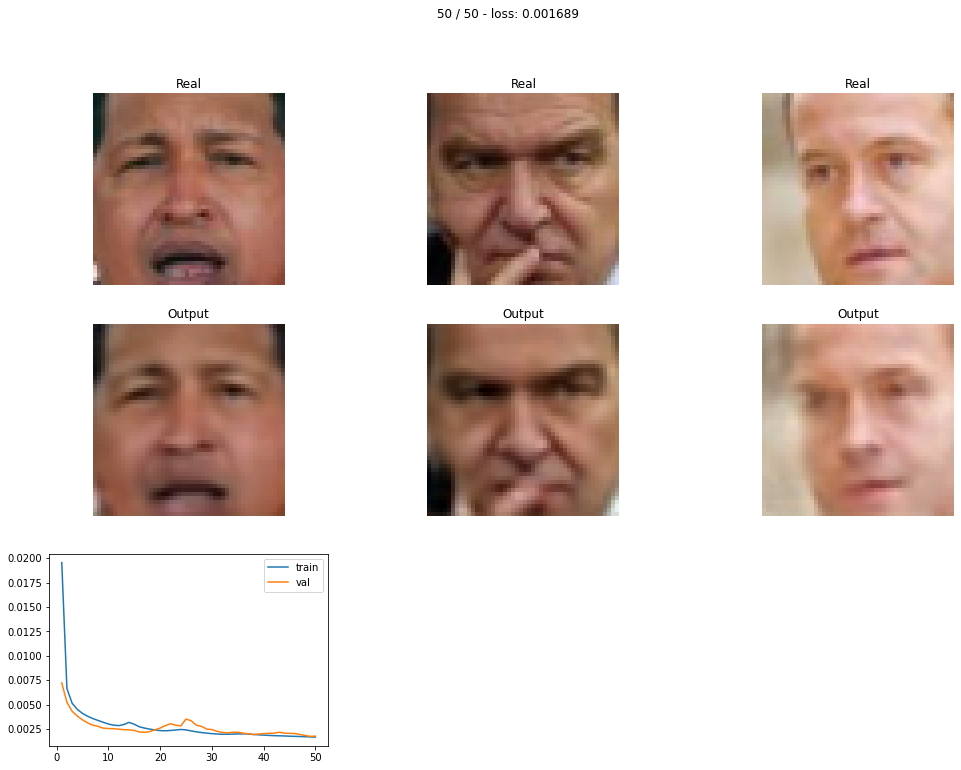

In [ ]:
# <тут Ваш код тренировки автоэнкодера>
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val = next(iter(data_val))

    train_loss, val_loss, val_acc = [], [], []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train() # train mode
        for X_tr_batch in data_tr:
            X_tr_batch = X_tr_batch.to(device) # data to device
            opt.zero_grad() # set parameter gradients to zero
            loss = loss_fn(X_tr_batch, model(X_tr_batch)[0]) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights
            avg_loss += loss / len(data_tr) # calculate loss to show the user

        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss)
        
        # show intermediate results
        model.eval() # testing mode
        X_val_pred = model(X_val.to(device))[0].detach().cpu() # detach and put into cpu

        sum_val_loss, sum_val_acc = 0, 0
        for X_val_batch in data_val:
            X_val_batch = X_val_batch.to(device)

            with torch.set_grad_enabled(False):
                vall_loss = loss_fn(X_val_batch, model(X_val_batch)[0])
            sum_val_loss += vall_loss

        val_loss.append(sum_val_loss / len(data_val))

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(17, 12))
        for k in range(3):
            plt.subplot(3, 3, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 3, k+4)
            plt.imshow(np.rollaxis(X_val_pred[k].numpy(), 0, 3))
            plt.title('Output')
            plt.axis('off')
        
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))

        plt.subplot(3, 3, 7)
        plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='train')
        plt.plot(np.arange(1, len(val_loss)+1), val_loss, label='val')
        
        plt.legend()
        plt.show()

    return train_loss, val_loss

train_losses, val_losses = train(autoencoder, optimizer, criterion, 50, data_train, data_val)

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


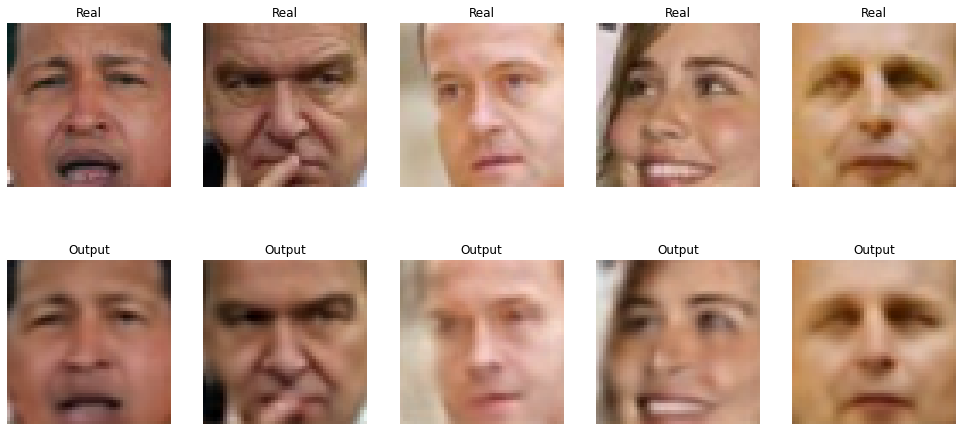

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
autoencoder.eval()
X_val = next(iter(data_val))
X_val_pred = autoencoder(X_val.to(device))[0].detach().cpu()
plt.figure(figsize=(17, 8))
for k in range(5):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3))
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, 5, k+6)
    plt.imshow(np.rollaxis(X_val_pred[k].numpy(), 0, 3))
    plt.title('Output')
    plt.axis('off')

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что придется рандом подогнать.

In [ ]:
lat_codes = autoencoder(X_val.to(device))[1].detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

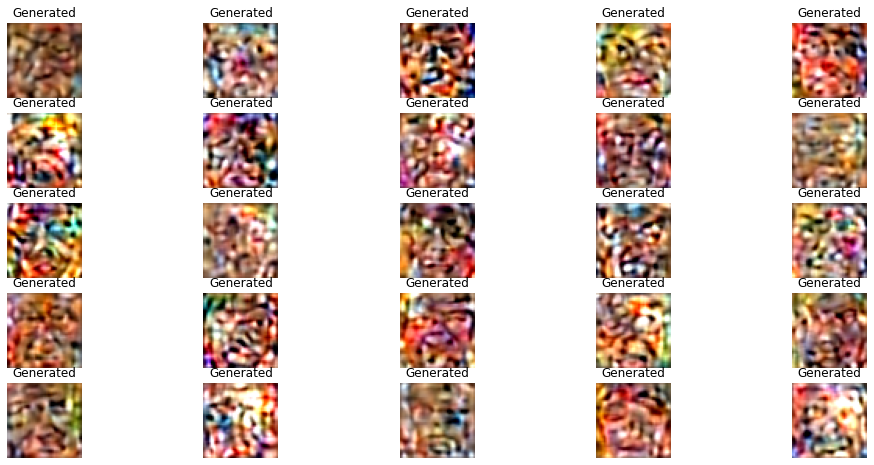

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = lat_codes.mean(axis=1).reshape(-1, 1) + lat_codes.std(axis=1).reshape(-1, 1) * np.random.randn(25, dim_code)
output = autoencoder.decode(torch.from_numpy(z).to(torch.float32).to(device)).detach().cpu()
plt.figure(figsize=(17, 8))
for k in range(25):
    plt.subplot(5, 5, k+1)
    plt.imshow(np.rollaxis(output[k].numpy(), 0, 3))
    plt.title('Generated')
    plt.axis('off')

In [ ]:
# torch.save(autoencoder, '/content/drive/MyDrive/Autoencoders/model_vanilla_ae')
# autoencoder = torch.load('/content/drive/MyDrive/Autoencoders/model_vanilla_ae')

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


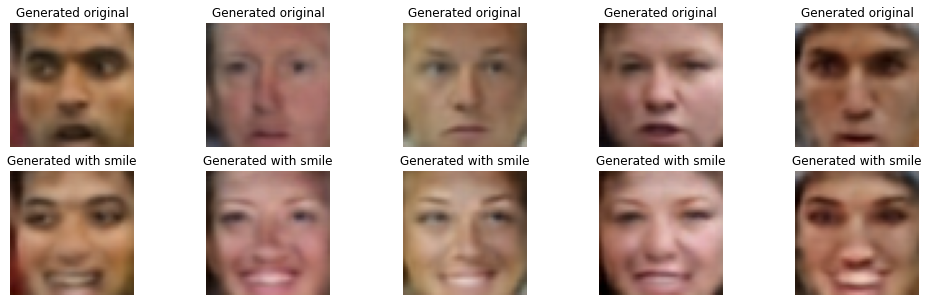

In [ ]:
# <а вот тут все это надо запрогать, да>

# 1
indexes_smile = np.array(attrs.sort_values('Smiling', ascending=False).head(15).index, dtype='int')
indexes_nosmile = np.array(attrs.sort_values('Smiling', ascending=True).head(15).index, dtype='int')
# 2
data_smile = torch.from_numpy(np.rollaxis(data[indexes_smile], 3, 1)).to(torch.float32)
data_nosmile = torch.from_numpy(np.rollaxis(data[indexes_nosmile], 3, 1)).to(torch.float32)

lat_codes_smile = autoencoder.encode(data_smile.to(device)).detach().cpu().numpy()
lat_codes_nosmile = autoencoder.encode(data_nosmile.to(device)).detach().cpu().numpy()

# 3
diff_in_codes = torch.from_numpy(lat_codes_smile.mean(axis=0) - lat_codes_nosmile.mean(axis=0)).to(torch.float32)

# 4
plt.figure(figsize=(17, 5))
for k in range(5):
    z = torch.from_numpy(lat_codes_nosmile[k]).to(torch.float32)

    plt.subplot(2, 5, k+1)
    plt.imshow(np.rollaxis(autoencoder.decode(z.to(device)).detach().cpu().squeeze(0).numpy(), 0, 3))
    plt.title('Generated original')
    plt.axis('off')

    plt.subplot(2, 5, k+6)
    plt.imshow(np.rollaxis(autoencoder.decode((z+diff_in_codes).to(device)).detach().cpu().squeeze(0).numpy(), 0, 3))
    plt.title('Generated with smile')
    plt.axis('off')

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
dim_code = 144

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU()
            ) # 28
        self.pool0 = nn.MaxPool2d(kernel_size=(2, 2)) # 28 -> 14

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU()
            ) # 14
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2)) # 14 -> 7

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(7*7*16, dim_code)
        self.fc2 = nn.Linear(7*7*16, dim_code)
        
        self.fc3 = nn.Sequential(
            nn.Linear(dim_code, 7*7*16),
            # nn.BatchNorm1d(7*7*16),
            nn.ReLU(),
            # nn.Dropout(0.5)
            )

        self.upsample0 = nn.Upsample(scale_factor=2) # 7 -> 14
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU()
            ) # 24
        
        self.upsample1 = nn.Upsample(scale_factor=2) # 14 -> 28
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), padding=(1, 1)),
            nn.Sigmoid()
            ) # 28
    
    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.enc_conv0(x)
        x = self.pool0(x)
        
        x = self.enc_conv1(x)
        x = self.pool1(x)
        
        x = self.flatten(x)

        mu = self.fc1(x)
        logsigma = self.fc2(x) # будет определяться как логарифм дисперсии

        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            return mu + torch.normal(mean=0, std=1, size=(1, dim_code)).to(device) * torch.sqrt(torch.exp(logsigma))
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве ваозвращаемой переменной -- reconstruction>
        x = self.fc3(z)
        x = torch.reshape(x, (-1, 16, 7, 7))

        x = self.upsample0(x)
        x = self.dec_conv0(x)

        x = self.upsample1(x)

        reconstruction = self.dec_conv1(x)
        
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве возвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    # <напишите код для KL-дивергенции, пользуясь формулой выше>
    loss = -1/2 * torch.mean(torch.sum((1 + logsigma - torch.square(mu) - torch.exp(logsigma)), dim=1))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = torch.nn.BCELoss() # <binary cross-entropy>
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    # <соедините тут две компоненты лосса. Mind the sign!>
    return 2 * KL_divergence(mu, logsigma) + 28*28 * log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), weight_decay=0.00) # <Ваш любимый оптимизатор>

In [ ]:
# сначала мини-код для скачивания MNIST
from torchvision import datasets
from torchvision import transforms

def get_dataloaders(batch_size):

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainset, testset, trainloader, testloader

train_set, val_set, data_train, data_val = get_dataloaders(50)

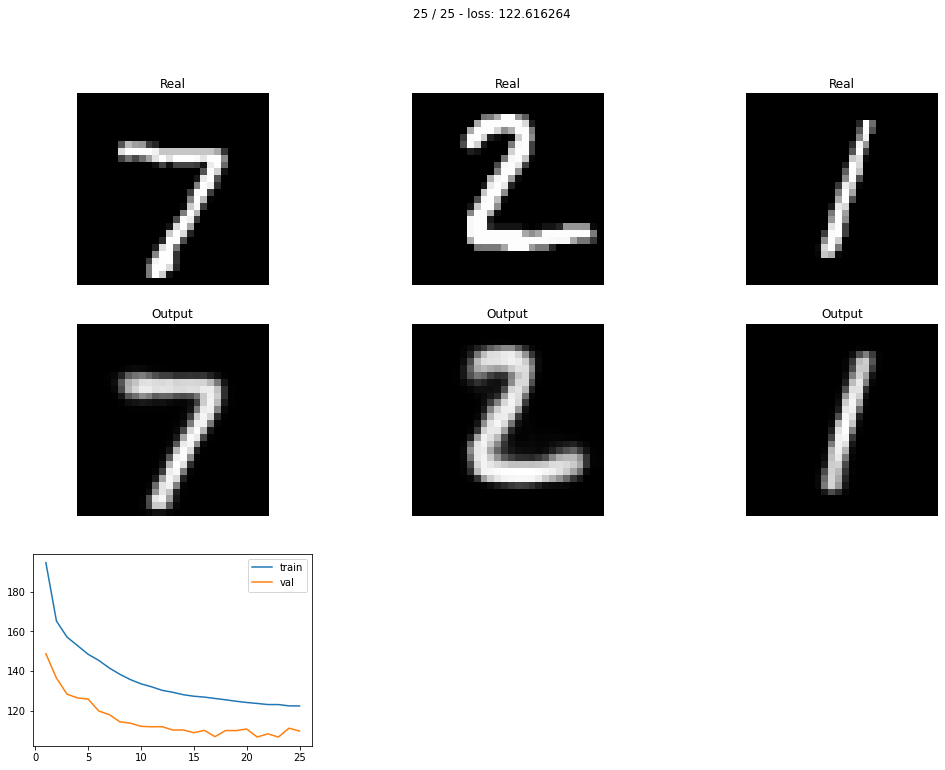

In [ ]:
# <обучите модель, как и autoencoder, но на датасете MNIST>
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, _ = next(iter(data_val))

    train_loss, val_loss = [], []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train() # train mode
        for X_tr_batch, _ in data_tr:
            X_tr_batch = X_tr_batch.to(device) # data to device
            opt.zero_grad() # set parameter gradients to zero

            loss = loss_fn(X_tr_batch, *model(X_tr_batch)) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights
            avg_loss += loss / len(data_tr) # calculate loss to show the user

        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss)
        
        # show intermediate results
        model.eval() # testing mode
        X_val_pred = model(X_val.to(device))[2].detach().cpu() # detach and put into cpu

        sum_val_loss = 0
        for X_val_batch, _ in data_val:
            X_val_batch = X_val_batch.to(device)

            with torch.set_grad_enabled(False):
                vall_loss = loss_fn(X_val_batch, *model(X_val_batch))
            sum_val_loss += vall_loss

        val_loss.append(sum_val_loss / len(data_val))

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(17, 12))
        for k in range(3):
            plt.subplot(3, 3, k+1)
            plt.imshow(np.squeeze(X_val[k].numpy()), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 3, k+4)
            plt.imshow(np.squeeze(X_val_pred[k].numpy()), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))

        plt.subplot(3, 3, 7)
        plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='train')
        plt.plot(np.arange(1, len(val_loss)+1), val_loss, label='val')
        
        plt.legend()
        plt.show()

    return train_loss, val_loss

train_losses, val_losses = train(autoencoder, optimizer, criterion, 25, data_train, data_val)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

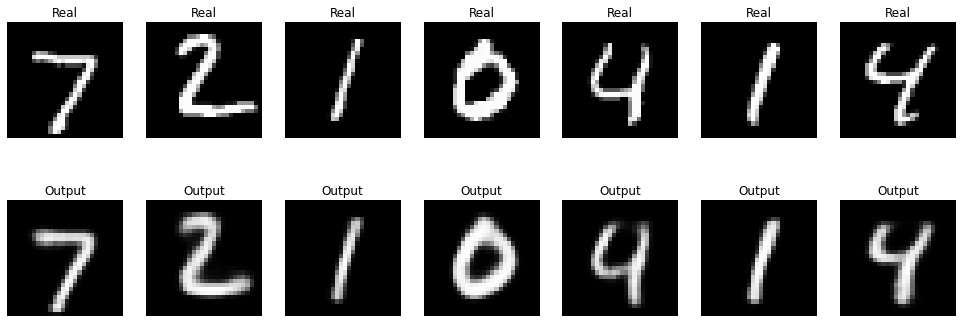

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
autoencoder.eval()
X_val = next(iter(data_val))[0]
X_val_pred = autoencoder(X_val.to(device))[2].detach().cpu()
plt.figure(figsize=(17, 6))

for k in range(7):
    plt.subplot(2, 7, k+1)
    plt.imshow(np.squeeze(X_val[k].numpy()), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, 7, k+8)
    plt.imshow(np.squeeze(X_val_pred[k].numpy()), cmap='gray')
    plt.title('Output')
    plt.axis('off')

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
autoencoder.eval()

VAE(
  (enc_conv0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=144, bias=True)
  (fc2): Linear(in_features=784, out_features=144, bias=True)
  (fc3): Sequential(
    (0): Linear(in_features=144, out_features=784, bias=True)
    (1): ReLU()
  )
  (upsample0): Upsample(scale_factor=2.0, mode=nearest)
  (dec_conv0): Sequential(
    (0): Conv2d(16, 32, ke

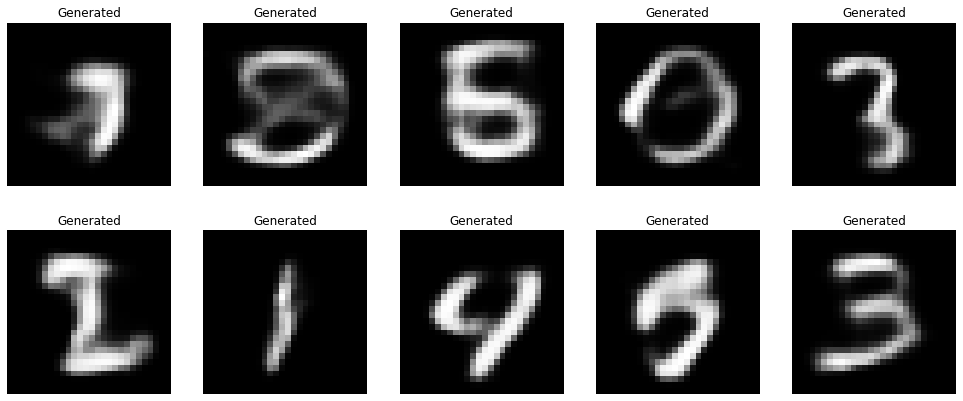

In [ ]:
# из стандартного нормального распределения
np.random.seed(42)
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, dim_code) for i in range(10)])
output = autoencoder.decode(torch.from_numpy(z).to(torch.float32).to(device)).detach().cpu()
# <выведите тут полученные картинки>
plt.figure(figsize=(17, 7))
for k in range(10):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(output[k].numpy()), cmap='gray')
    plt.title('Generated')
    plt.axis('off')

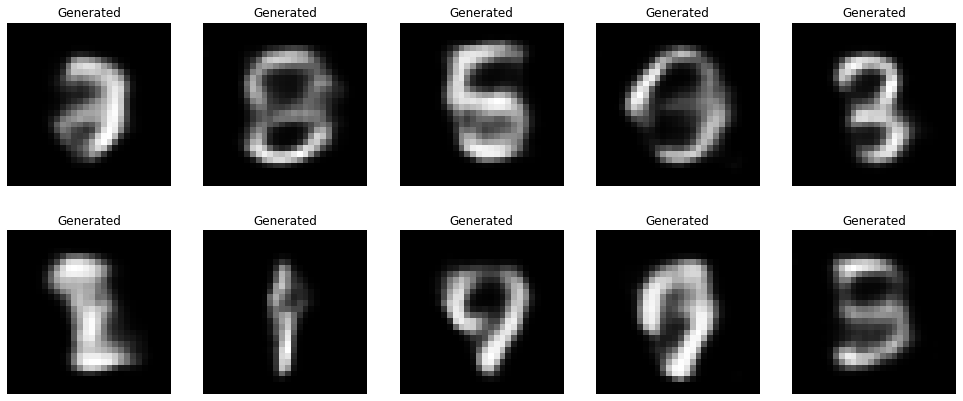

In [ ]:
# скорректированное нормальное распределение
lat_codes_mu, lat_codes_logsigma = autoencoder.encode(X_val.to(device))
lat_codes_mu = torch.mean(lat_codes_mu, axis=0).detach().cpu().numpy()
lat_codes_std = torch.mean(torch.sqrt(torch.exp(lat_codes_logsigma)), axis=0).detach().cpu().numpy()

np.random.seed(42)
z = np.array([lat_codes_mu + lat_codes_std * np.random.normal(0, 1, dim_code) for i in range(10)])
output = autoencoder.decode(torch.from_numpy(z).to(torch.float32).to(device)).detach().cpu()

plt.figure(figsize=(17, 7))
for k in range(10):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(output[k].numpy()), cmap='gray')
    plt.title('Generated')
    plt.axis('off')

Некоторые картинки при корректировке стали лучше, некоторые хуже, в целом вроде неплохо вышло)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
# torch.save(autoencoder, '/content/drive/MyDrive/Autoencoders/model_variational_ae')
# autoencoder = torch.load('/content/drive/MyDrive/Autoencoders/model_variational_ae')

Codes are ready
Embeddings are ready


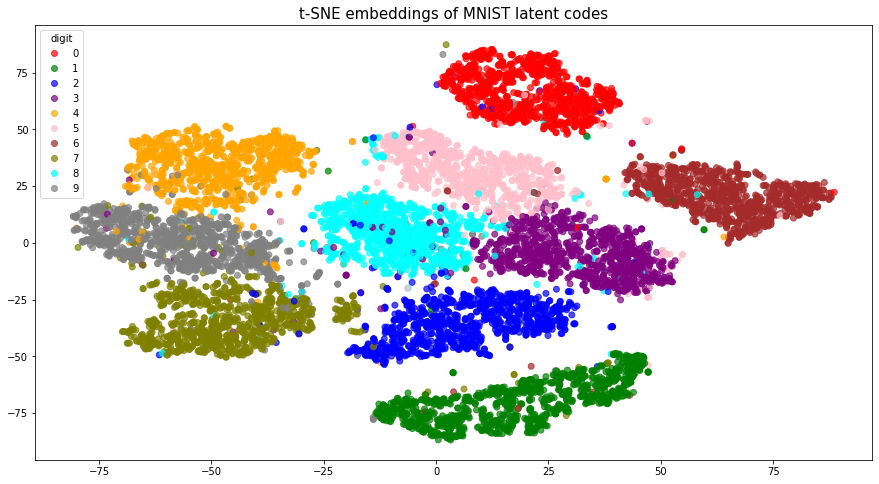

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
autoencoder.eval()
# 1
X_val, y_val = val_set.data.unsqueeze(1).to(torch.float32), val_set.targets
lat_codes_mu_vects, _ = autoencoder.encode(X_val.to(device))
print('Codes are ready')
# 2
from sklearn.manifold import TSNE
lat_codes_mu_embedded = TSNE(n_components=2).fit_transform(lat_codes_mu_vects.detach().cpu().numpy())
print('Embeddings are ready')
# 3
dict_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple', 4: 'orange',
               5: 'pink', 6: 'brown', 7: 'olive', 8: 'cyan', 9: 'gray'}
labels = y_val.numpy()

import matplotlib
plt.figure(figsize=(15, 8))
scatter = plt.scatter(lat_codes_mu_embedded[:, 0], lat_codes_mu_embedded[:, 1], alpha=0.7,
                      c=list(labels), cmap=matplotlib.colors.ListedColormap(list(dict_colors.values())))
plt.legend(handles=scatter.legend_elements()[0], labels=list(dict_colors.keys()), title='digit')
plt.title('t-SNE embeddings of MNIST latent codes', fontsize=15)
plt.show()

Что вы думаете о виде латентного представления?

Хорошо отделились от других кластеры __0__, __1__ и __6__. Близки к друг к другу оказались кластеры 3, 5 и 8 (в общем-то, в них есть что-то схожее, правда я бы к ним и 6 добавил). В целом, латентное представление должно быть достаточно хорошо разделяет цифры.

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

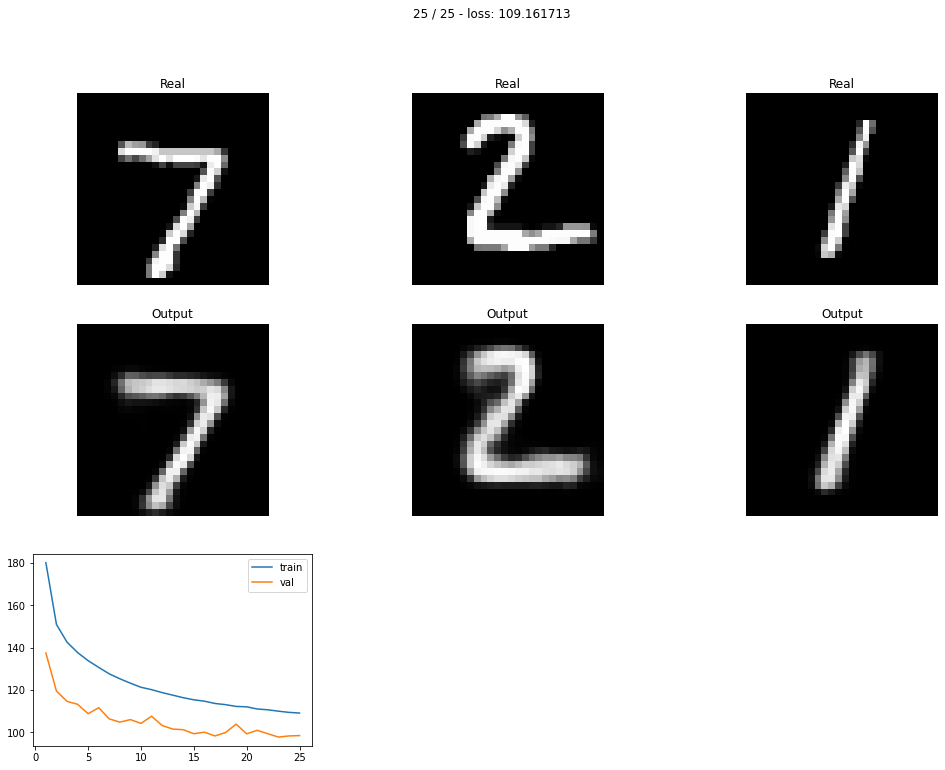

In [ ]:
# <тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>
dim_code = 144

class CVAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU()
            ) # 28
        self.pool0 = nn.MaxPool2d(kernel_size=(2, 2)) # 28 -> 14

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU()
            ) # 14
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2)) # 14 -> 7

        self.flatten = nn.Flatten()

        self.fc0 = nn.Sequential(
            nn.Linear(7*7*16+10, 392),
            nn.BatchNorm1d(392),
            nn.ReLU()
            ) # добавил ешё один слой, чтобы точно извлечь информацию с ohe значения цифры
        
        self.fc1 = nn.Linear(392+10, dim_code)
        self.fc2 = nn.Linear(392+10, dim_code)
        
        self.fc3 = nn.Sequential(
            nn.Linear(dim_code+10,  7*7*16), # без BatchNorm1d обучение прошло в разы адекватнее :)
            nn.ReLU()
            )
        
        self.upsample0 = nn.Upsample(scale_factor=2) # 7 -> 14
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU()
            ) # 24
        
        self.upsample1 = nn.Upsample(scale_factor=2) # 14 -> 28
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), padding=(1, 1)),
            nn.Sigmoid()
            ) # 28
    
    def encode(self, x, y):
        x = self.enc_conv0(x)
        x = self.pool0(x)
        
        x = self.enc_conv1(x)
        x = self.pool1(x)
        
        x = torch.cat((self.flatten(x), F.one_hot(y, num_classes=10)), axis=1) # свёртки только для самой картинки, поэтому лейбл сразу сюда
        x = self.fc0(x)

        mu = self.fc1(torch.cat((x, F.one_hot(y, num_classes=10)), axis=1)) # и сюда
        logsigma = self.fc2(torch.cat((x, F.one_hot(y, num_classes=10)), axis=1)) # и сюда

        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            return mu + torch.normal(mean=0, std=1, size=(1, dim_code)).to(device) * torch.sqrt(torch.exp(logsigma))
        else:
            return mu
    
    def decode(self, z, y):
        x = self.fc3(torch.cat((z, F.one_hot(y, num_classes=10)), axis=1))
        x = torch.reshape(x, (-1, 16, 7, 7))

        x = self.upsample0(x)
        x = self.dec_conv0(x)

        x = self.upsample1(x)

        reconstruction = self.dec_conv1(x)

        return reconstruction

    def forward(self, x, y):
        mu, logsigma = self.encode(x, y)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, y)
        
        return mu, logsigma, reconstruction

# loss, model and optimizer
criterion = loss_vae
autoencoder = CVAE().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), weight_decay=0.00)

# функция обучения
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, y_val = next(iter(data_val))

    train_loss, val_loss = [], []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train() # train mode
        for X_tr_batch, y_tr_batch in data_tr:
            X_tr_batch, y_tr_batch = X_tr_batch.to(device), y_tr_batch.to(device) # data to device

            opt.zero_grad() # set parameter gradients to zero

            loss = loss_fn(X_tr_batch, *model(X_tr_batch, y_tr_batch)) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights
            avg_loss += loss / len(data_tr) # calculate loss to show the user

        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss)
        
        # show intermediate results
        model.eval() # testing mode
        X_val_pred = model(X_val.to(device), y_val.to(device))[2].detach().cpu() # detach and put into cpu

        sum_val_loss = 0
        for X_val_batch, y_val_batch in data_val:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            with torch.set_grad_enabled(False):
                vall_loss = loss_fn(X_val_batch, *model(X_val_batch, y_val_batch))
            sum_val_loss += vall_loss

        val_loss.append(sum_val_loss / len(data_val))

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(17, 12))
        for k in range(3):
            plt.subplot(3, 3, k+1)
            plt.imshow(np.squeeze(X_val[k].numpy()), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 3, k+4)
            plt.imshow(np.squeeze(X_val_pred[k].numpy()), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))

        plt.subplot(3, 3, 7)
        plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='train')
        plt.plot(np.arange(1, len(val_loss)+1), val_loss, label='val')
        
        plt.legend()
        plt.show()

    return train_loss, val_loss

train_losses, val_losses = train(autoencoder, optimizer, criterion, 25, data_train, data_val)
# torch.save(autoencoder, '/content/drive/MyDrive/Autoencoders/model_conditional_vae')

# autoencoder = torch.load('/content/drive/MyDrive/Autoencoders/model_conditional_vae')

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

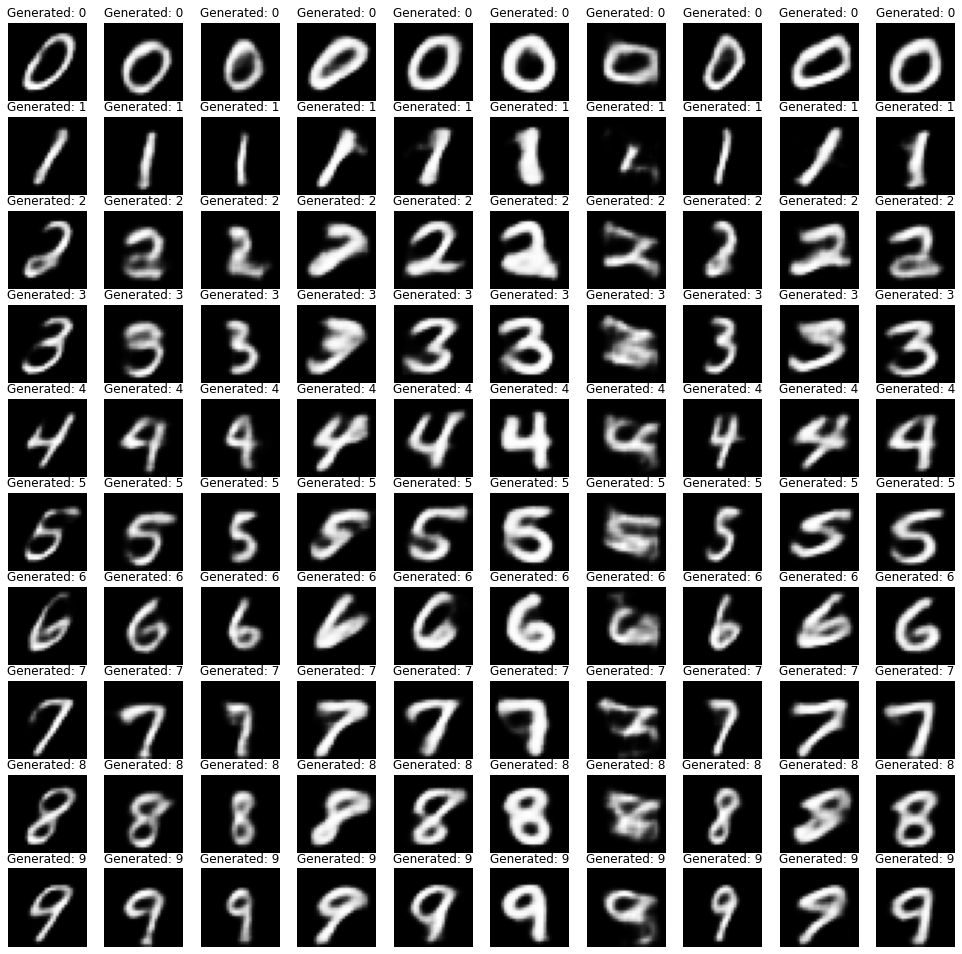

In [ ]:
autoencoder.eval()
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
np.random.seed(42)
z = np.array([np.random.normal(0, 1, dim_code) for i in range(10)])
z = torch.from_numpy(z).to(torch.float32).to(device)

plt.figure(figsize=(17, 17))
for digit in range(10):
    y = torch.from_numpy(np.ones((10))).to(torch.int64).to(device) * digit
    output = autoencoder.decode(z, y.to(torch.int64)).detach().cpu()
    for k in range(10):
        plt.subplot(10, 10, digit*10 + k + 1)
        plt.imshow(np.squeeze(output[k].numpy()), cmap='gray')
        plt.title('Generated' + ': ' + str(digit))
        plt.axis('off')

Splendid! Вы великолепны!

Ну круто же, ну? __Агааа)__

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

Codes are ready
Embeddings are ready


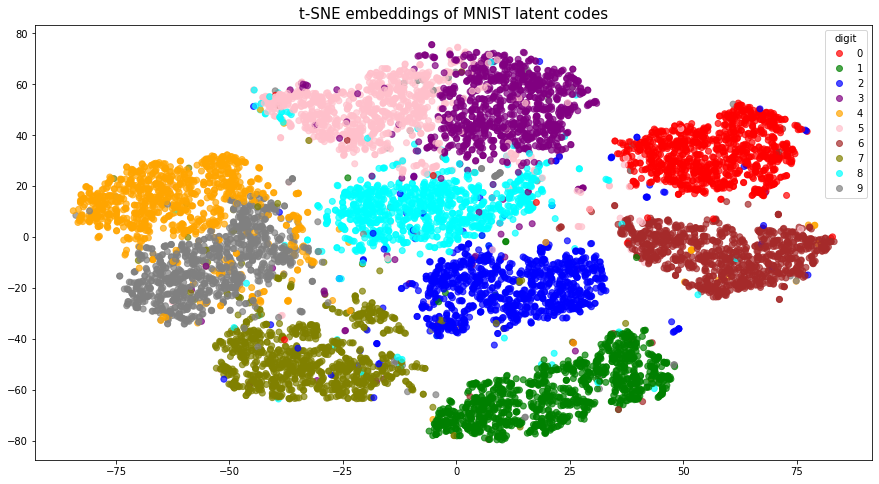

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
autoencoder.eval()
# 1
X_val, y_val = val_set.data.unsqueeze(1).to(torch.float32), val_set.targets
lat_codes_mu_vects, _ = autoencoder.encode(X_val.to(device), y_val.to(device))
print('Codes are ready')
# 2
from sklearn.manifold import TSNE
lat_codes_mu_embedded = TSNE(n_components=2).fit_transform(lat_codes_mu_vects.detach().cpu().numpy())
print('Embeddings are ready')
# 3
dict_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple', 4: 'orange',
               5: 'pink', 6: 'brown', 7: 'olive', 8: 'cyan', 9: 'gray'}
labels = y_val.numpy()

import matplotlib
plt.figure(figsize=(15, 8))
scatter = plt.scatter(lat_codes_mu_embedded[:, 0], lat_codes_mu_embedded[:, 1], alpha=0.7,
                      c=list(labels), cmap=matplotlib.colors.ListedColormap(list(dict_colors.values())))
plt.legend(handles=scatter.legend_elements()[0], labels=list(dict_colors.keys()), title='digit')
plt.title('t-SNE embeddings of MNIST latent codes', fontsize=15)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Особых отличий не увидел: кластеры, которые были близки друг к другу, так и остались близки (став чуть более разделёнными), правда общее расположение кластеров смотрится более гармонично)

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
# сначала подготовим данные
%cd /content/drive/MyDrive/Autoencoders
with open('data.npy', 'rb') as f:
    data = np.load(f)
print(data.shape)

attrs = pd.read_csv('attrs.csv', header=0)
print(attrs.shape)

np.random.seed(42)
train_part, val_part = np.split(np.random.permutation(np.arange(data.shape[0])), [int(data.shape[0] * 0.8)])

X_train, X_val, attrs_train, attrs_val = data[train_part], data[val_part], attrs.iloc[train_part], attrs.iloc[val_part]

X_train_t = torch.from_numpy(np.rollaxis(X_train, 3, 1)).to(torch.float32)
X_val_t = torch.from_numpy(np.rollaxis(X_val, 3, 1)).to(torch.float32)

from torch.utils.data import DataLoader
batch_size = 25
data_train = DataLoader(X_train_t, batch_size=batch_size, shuffle=False)
data_val = DataLoader(X_val_t, batch_size=batch_size, shuffle=False)

/content/drive/MyDrive/Autoencoders
(13143, 48, 48, 3)
(13143, 73)


In [ ]:
# <тут ваш код>
# Сначала код VAE для лиц (также использую в бонусном пункте 2)
dim_code = 288

class VAE_faces(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv01 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), padding=(2, 2)),
            nn.BatchNorm2d(64),
            nn.ReLU()
            ) # 48
        self.enc_conv02 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU()
            ) # 48
        self.pool0 = nn.MaxPool2d(kernel_size=(2, 2), return_indices=True) # 48 -> 24
        # nn.MaxPool2d(kernel_size=(2, 2), return_indices=True)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
            ) # 24
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), return_indices=True) # 24 -> 12

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU()
            ) # 12
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), return_indices=True) # 12 -> 6

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(6*6*16, dim_code)
        self.fc2 = nn.Linear(6*6*16, dim_code)
        
        self.fc3 = nn.Sequential(
            nn.Linear(dim_code, 6*6*16),
            nn.ReLU()
            )
        
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 12 -> 24
        # nn.MaxUnpool2d(kernel_size=2, stride=2)
        # nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
            ) # 12
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 12 -> 24
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
            ) # 24
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 24 -> 48
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=3, kernel_size=(3, 3), padding=(1, 1)),
            nn.Sigmoid()
            ) # 48
    
    def encode(self, x):
        x = torch.cat((self.enc_conv01(x), self.enc_conv02(x)), dim=1)
        x, indices0 = self.pool0(x)
        x, indices1 = self.pool1(self.enc_conv1(x))
        x, indices2 = self.pool2(self.enc_conv2(x))
        # x = self.pool0(x)
        # x = self.pool1(self.enc_conv1(x))
        # x = self.pool2(self.enc_conv2(x))

        x = self.flatten(x)

        mu = self.fc1(x)
        logsigma = self.fc2(x) # будет определяться как логарифм дисперсии

        return mu, logsigma, indices0, indices1, indices2
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            return mu + torch.normal(mean=0, std=1, size=(1, dim_code)).to(device) * torch.sqrt(torch.exp(logsigma))
        else:
            return mu
    
    def decode(self, z, indices0, indices1, indices2):
        x = self.fc3(z)
        x = torch.reshape(x, (-1, 16, 6, 6))

        x = self.dec_conv0(self.upsample0(x, indices2))
        x = self.dec_conv1(self.upsample1(x, indices1))
        reconstruction = self.dec_conv2(self.upsample2(x, indices0))
        
        # x = self.dec_conv0(self.upsample0(x))
        # x = self.dec_conv1(self.upsample1(x))
        # reconstruction = self.dec_conv2(self.upsample2(x))
        
        return reconstruction

    def forward(self, x):
        mu, logsigma, indices0, indices1, indices2 = self.encode(x)
        # mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, indices0, indices1, indices2)

        return mu, logsigma, reconstruction

# Куски лосса
def KL_divergence(mu, logsigma):
    loss = -1/2 * torch.mean(torch.sum((1 + logsigma - torch.square(mu) - torch.exp(logsigma)), dim=1))
    return loss

def mse_loss(x, reconstruction):
    loss = torch.nn.BCELoss() # пробовал MSELoss, качество немного хуже
    return loss(reconstruction, x)

def loss_vae_faces(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + 48*48 * mse_loss(x, reconstruction)

# loss, model and optimizer
criterion = loss_vae_faces
autoencoder = VAE_faces().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), weight_decay=0.00)

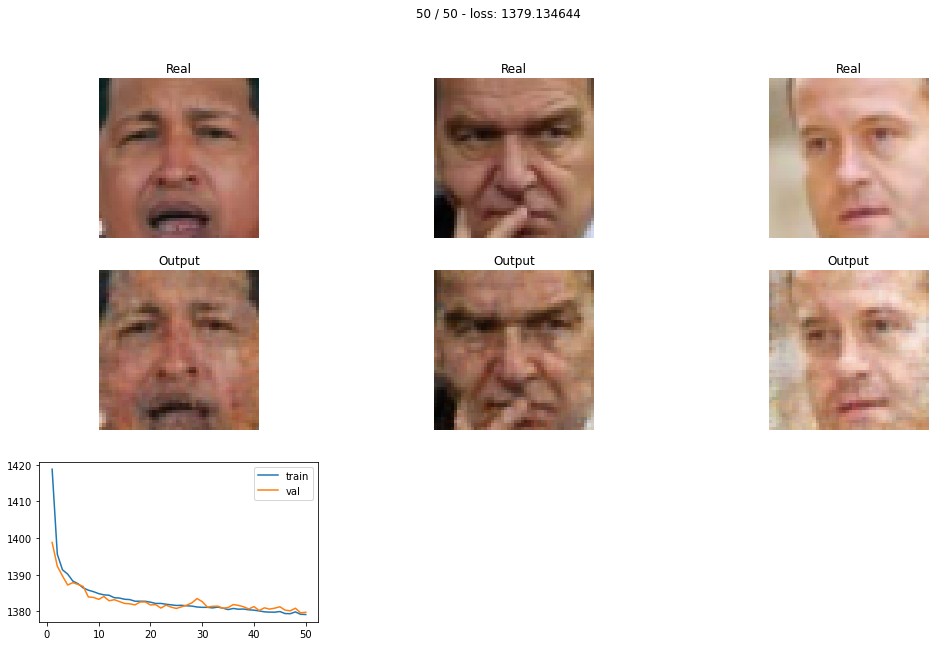

In [ ]:
# обучаем модель
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val = next(iter(data_val))

    train_loss, val_loss = [], []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train() # train mode
        for X_tr_batch in data_tr:
            X_tr_batch = X_tr_batch.to(device) # data to device
            opt.zero_grad() # set parameter gradients to zero

            loss = loss_fn(X_tr_batch, *model(X_tr_batch)) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights
            avg_loss += loss / len(data_tr) # calculate loss to show the user

        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss)
        
        # show intermediate results
        model.eval() # testing mode
        X_val_pred = model(X_val.to(device))[2].detach().cpu() # detach and put into cpu

        sum_val_loss = 0
        for X_val_batch in data_val:
            X_val_batch = X_val_batch.to(device)

            with torch.set_grad_enabled(False):
                vall_loss = loss_fn(X_val_batch, *model(X_val_batch))
            sum_val_loss += vall_loss

        val_loss.append(sum_val_loss / len(data_val))

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(17, 10))
        for k in range(3):
            plt.subplot(3, 3, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 3, k+4)
            plt.imshow(np.rollaxis(X_val_pred[k].numpy(), 0, 3))
            plt.title('Output')
            plt.axis('off')
        
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))

        plt.subplot(3, 3, 7)
        plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='train')
        plt.plot(np.arange(1, len(val_loss)+1), val_loss, label='val')
        
        plt.legend()
        plt.show()

    return train_loss, val_loss

train_losses, val_losses = train(autoencoder, optimizer, criterion, 50, data_train, data_val)

In [ ]:
# from torchsummary import summary
# summary(autoencoder, (3, 48, 48))

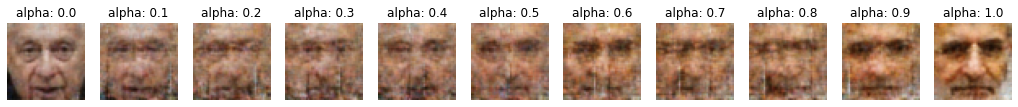

In [ ]:
autoencoder.eval()

# как уже можно было заметить в архитектуре, использовался max unpooling с использованием индексов,
# поэтому дальше придётся их тоже как-то усреднять
# своего рода, получился вынужденный эксперимент :) посмотрим что выйдет
lat_code_1, _, ind11, ind12, ind13 = autoencoder.encode(X_val_t[-2].unsqueeze(0).to(device))
lat_code_2, _, ind21, ind22, ind23 = autoencoder.encode(X_val_t[-1].unsqueeze(0).to(device))

plt.figure(figsize=(18, 4))
for i, alpha in enumerate(np.arange(0, 1.1, 0.1)):
    lat_code = (1-alpha) * lat_code_1 + alpha * lat_code_2
    ind1 = torch.round((1-alpha) * ind11 + alpha * ind21).to(torch.int64)
    ind2 = torch.round((1-alpha) * ind12 + alpha * ind22).to(torch.int64)
    ind3 = torch.round((1-alpha) * ind13 + alpha * ind23).to(torch.int64)
    X_pred = autoencoder.decode(lat_code, ind1, ind2, ind3).detach().cpu().squeeze(0)

    plt.subplot(1, 11, i+1)
    plt.imshow(np.rollaxis(X_pred.numpy(), 0, 3))
    plt.title('alpha: ' + str(round(alpha, 1)))
    plt.axis('off')

Превращение вышло не такое магическое, как в примере)))

In [ ]:
# torch.save(autoencoder, '/content/drive/MyDrive/Autoencoders/model_vae_faces_b1')
# autoencoder = torch.load('/content/drive/MyDrive/Autoencoders/model_vae_faces_b1')

# BONUS 2: Denoising (2 балла) -- только первая часть

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
# noise_factor = 0.5
# X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

Будем добавлять шум внутри цикла тренировки, таким образом одна и та же тренировочная картинка будет получать разный (с очень высокой вероятностью) шум при каждой эпохе, что, мне кажется, должно сделать алгоритм более сильным на валидации.

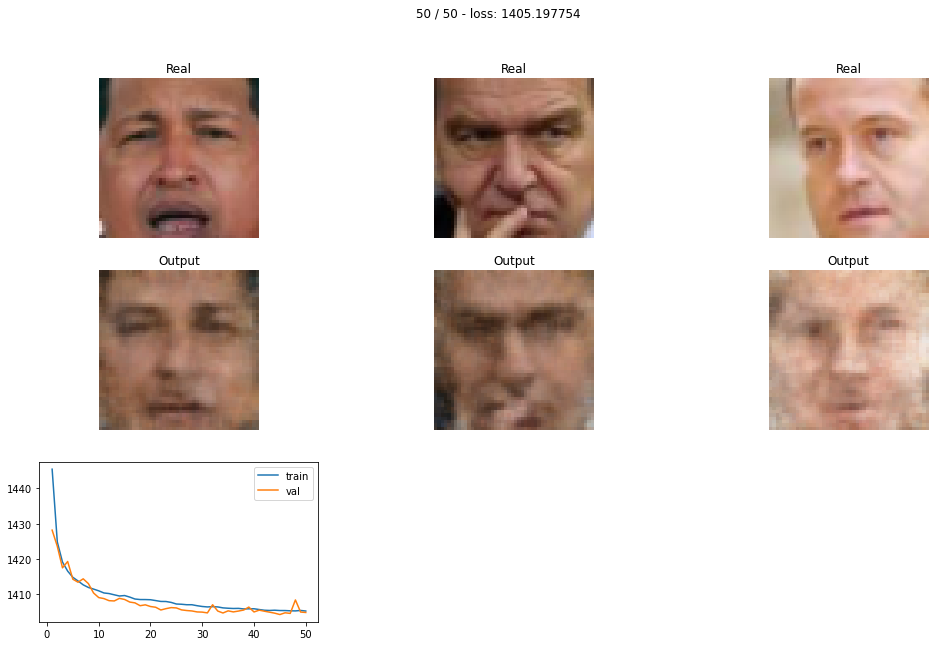

In [ ]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>
criterion = loss_vae_faces
autoencoder = VAE_faces().to(device) # сетка та же, что и в предыдущем бонусном пункте
optimizer = torch.optim.Adam(autoencoder.parameters(), weight_decay=0.00)

def train(model, opt, loss_fn, epochs, data_tr, data_val):
    noise_factor = 0.5

    y_val = next(iter(data_val))
    X_val = y_val + noise_factor * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0,
                                                                     size=y_val.shape)).to(torch.float32)

    train_loss, val_loss = [], []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train() # train mode
        for y_tr_batch in data_tr:
            # Будем добавлять шум внутри цикла тренировки, таким образом одна и та же тренировочная картинка будет 
            # получать разный (с очень высокой вероятностью) шум при каждой эпохе, что, мне кажется, 
            # должно сделать алгоритм более сильным на валидации.
            X_tr_batch = y_tr_batch + noise_factor * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0,
                                                                                       size=y_tr_batch.shape)).to(torch.float32)
            X_tr_batch, y_tr_batch = X_tr_batch.to(device), y_tr_batch.to(device) # data to device
            opt.zero_grad() # set parameter gradients to zero

            loss = loss_fn(y_tr_batch, *model(X_tr_batch)) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights
            avg_loss += loss / len(data_tr) # calculate loss to show the user

        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss)
        
        # show intermediate results
        model.eval() # testing mode
        y_val_pred = model(X_val.to(device))[2].detach().cpu() # detach and put into cpu

        sum_val_loss = 0
        for y_val_batch in data_val:
            X_val_batch = y_val_batch + noise_factor * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0,
                                                                                         size=y_val_batch.shape)
                                                                                         ).to(torch.float32)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            with torch.set_grad_enabled(False):
                vall_loss = loss_fn(y_val_batch, *model(X_val_batch))
            sum_val_loss += vall_loss

        val_loss.append(sum_val_loss / len(data_val))

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(17, 10))
        for k in range(3):
            plt.subplot(3, 3, k+1)
            plt.imshow(np.rollaxis(y_val[k].numpy(), 0, 3))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 3, k+4)
            plt.imshow(np.rollaxis(y_val_pred[k].numpy(), 0, 3))
            plt.title('Output')
            plt.axis('off')
        
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))

        plt.subplot(3, 3, 7)
        plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='train')
        plt.plot(np.arange(1, len(val_loss)+1), val_loss, label='val')
        
        plt.legend()
        plt.show()

    return train_loss, val_loss

train_losses, val_losses = train(autoencoder, optimizer, criterion, 50, data_train, data_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


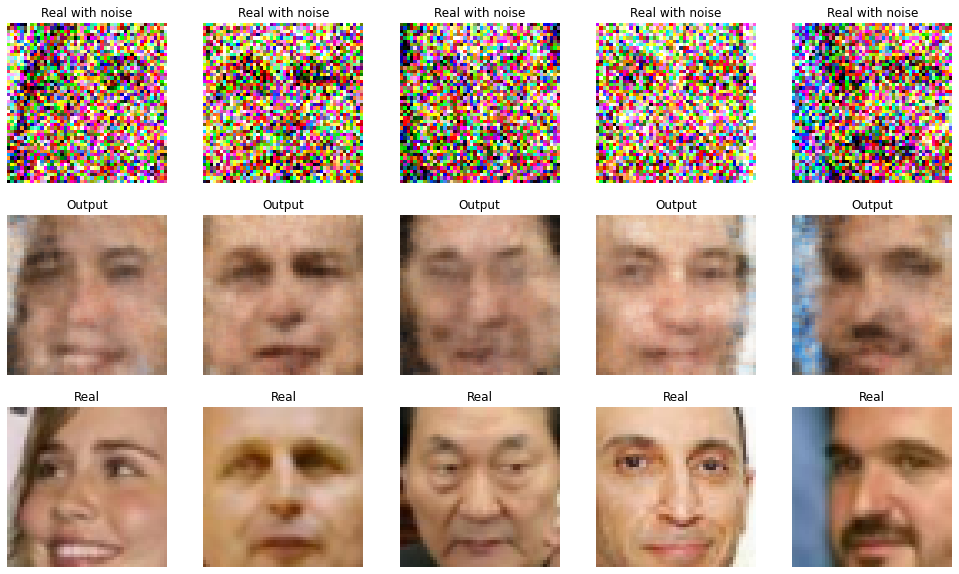

In [ ]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>
autoencoder.eval()
y_val = next(iter(data_val))
X_val = y_val + 0.5 * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0,
                                                        size=y_val.shape)).to(torch.float32)
y_val_pred = autoencoder(X_val.to(device))[2].detach().cpu()

plt.figure(figsize=(17, 10))
for k in range(5):
    plt.subplot(3, 5, k+1)
    plt.imshow(np.rollaxis(X_val[k+3].numpy(), 0, 3)) # добавил +3, чтобы глянуть на других людей, верхние надоели)
    plt.title('Real with noise')
    plt.axis('off')

    plt.subplot(3, 5, k+6)
    plt.imshow(np.rollaxis(y_val_pred[k+3].numpy(), 0, 3))
    plt.title('Output')
    plt.axis('off')

    plt.subplot(3, 5, k+11)
    plt.imshow(np.rollaxis(y_val[k+3].numpy(), 0, 3))
    plt.title('Real')
    plt.axis('off')

На месте нейросети я бы даже при наличии итоговых картинок не смог бы их сопоставить с их зашумлёнными аналогами)

In [ ]:
# torch.save(autoencoder, '/content/drive/MyDrive/Autoencoders/model_vae_faces_b2')
# autoencoder = torch.load('/content/drive/MyDrive/Autoencoders/model_vae_faces_b2')

В условии пункта говорилось про AE, это натолкнуло меня на мысль "Почему бы не попробовать обычный AE?". В отличие от первого бонусного пункта это не кажется плохой идеей (там бы мы могли попасть в промежуточные латентные вектора, которые нейросеть совсем не видела и выдала бы что-то похожее на шум). Напишем класс AE, только сделаем его чуть внушительнее по сравнению с самым первым ванильным.

In [ ]:
dim_code = 288 * 2 # увеличил размерность в два раза, ибо не надо обучать сигмы
# возможно, это и сыграет ключевую роль далее, так как мы теряем меньше информации в "горлышке"

class AE_faces(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder>
        super().__init__()

        self.enc_conv01 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 5), padding=(2, 2)),
            nn.BatchNorm2d(32),
            nn.ReLU()
            ) # 48
        self.enc_conv02 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU()
            ) # 48
        self.pool0 = nn.MaxPool2d(kernel_size=(2, 2)) # 48 -> 24

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU()
            ) # 24
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2)) # 24 -> 12

        self.flatten = nn.Flatten()

        self.fc0 = nn.Sequential(
            nn.Linear(12*12*16, 1000),
            nn.ReLU()
            )
        
        self.fc1 = nn.Linear(1000, dim_code)

        self.fc2 = nn.Sequential(
            nn.Linear(dim_code, 12*12*8),
            nn.ReLU()
            )

        self.upsample0 = nn.Upsample(scale_factor=2) # 12 -> 24
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU()
            ) # 24
        
        self.upsample1 = nn.Upsample(scale_factor=2) # 24 -> 48
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=(3, 3), padding=(1, 1)),
            nn.Sigmoid()
            ) # 48
    
    def encode(self, x):
        x = self.pool0(torch.cat((self.enc_conv01(x), self.enc_conv02(x)), dim=1))        
        x = self.pool1(self.enc_conv1(x))

        return self.fc1(self.fc0(self.flatten(x)))
    
    def decode(self, latent_code):
        x = self.fc2(latent_code)
        x = torch.reshape(x, (-1, 8, 12, 12))

        x = self.dec_conv0(self.upsample0(x))
        return self.dec_conv1(self.upsample1(x))

    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)

        return reconstruction, latent_code

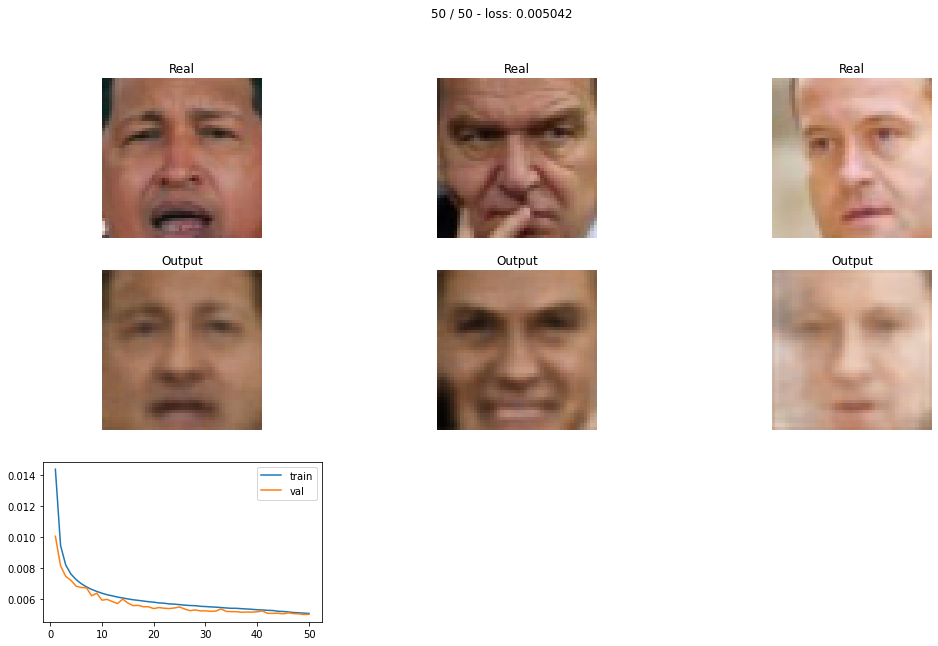

In [ ]:
criterion = torch.nn.MSELoss()
autoencoder = AE_faces().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), weight_decay=0.00)

# такой же по сути код тренировки, только пару вещей подкорректировал под данную модель
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    noise_factor = 0.5

    y_val = next(iter(data_val))
    X_val = y_val + noise_factor * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0,
                                                                     size=y_val.shape)).to(torch.float32)

    train_loss, val_loss = [], []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train() # train mode
        for y_tr_batch in data_tr:
            # Будем добавлять шум внутри цикла тренировки, таким образом одна и та же тренировочная картинка будет
            # получать разный (с очень высокой вероятностью) шум при каждой эпохе, что, мне кажется, 
            # должно сделать алгоритм более сильным на валидации.
            X_tr_batch = y_tr_batch + noise_factor * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0,
                                                                                       size=y_tr_batch.shape)
                                                                                       ).to(torch.float32)
            X_tr_batch, y_tr_batch = X_tr_batch.to(device), y_tr_batch.to(device) # data to device
            opt.zero_grad() # set parameter gradients to zero

            loss = loss_fn(y_tr_batch, model(X_tr_batch)[0]) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights
            avg_loss += loss / len(data_tr) # calculate loss to show the user

        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss)
        
        # show intermediate results
        model.eval() # testing mode
        y_val_pred = model(X_val.to(device))[0].detach().cpu() # detach and put into cpu

        sum_val_loss = 0
        for y_val_batch in data_val:
            X_val_batch = y_val_batch + noise_factor * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0,
                                                                                         size=y_val_batch.shape)
                                                                                         ).to(torch.float32)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            with torch.set_grad_enabled(False):
                vall_loss = loss_fn(y_val_batch, model(X_val_batch)[0])
            sum_val_loss += vall_loss

        val_loss.append(sum_val_loss / len(data_val))

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(17, 10))
        for k in range(3):
            plt.subplot(3, 3, k+1)
            plt.imshow(np.rollaxis(y_val[k].numpy(), 0, 3))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 3, k+4)
            plt.imshow(np.rollaxis(y_val_pred[k].numpy(), 0, 3))
            plt.title('Output')
            plt.axis('off')
        
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))

        plt.subplot(3, 3, 7)
        plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='train')
        plt.plot(np.arange(1, len(val_loss)+1), val_loss, label='val')
        
        plt.legend()
        plt.show()

    return train_loss, val_loss

train_losses, val_losses = train(autoencoder, optimizer, criterion, 50, data_train, data_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


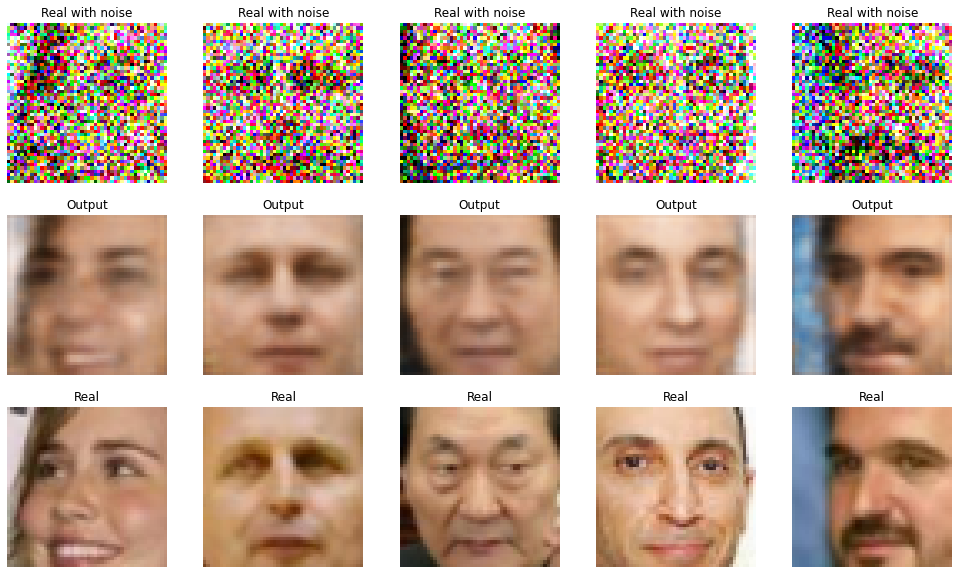

In [ ]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>
autoencoder.eval()
y_val = next(iter(data_val))
X_val = y_val + 0.5 * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0,
                                                        size=y_val.shape)).to(torch.float32)
y_val_pred = autoencoder(X_val.to(device))[0].detach().cpu()

plt.figure(figsize=(17, 10))
for k in range(5):
    plt.subplot(3, 5, k+1)
    plt.imshow(np.rollaxis(X_val[k+3].numpy(), 0, 3)) # добавил +3, чтобы глянуть на других людей, верхние надоели)
    plt.title('Real with noise')
    plt.axis('off')

    plt.subplot(3, 5, k+6)
    plt.imshow(np.rollaxis(y_val_pred[k+3].numpy(), 0, 3))
    plt.title('Output')
    plt.axis('off')

    plt.subplot(3, 5, k+11)
    plt.imshow(np.rollaxis(y_val[k+3].numpy(), 0, 3))
    plt.title('Real')
    plt.axis('off')

Восстановленные изображения получились более плавные, но детализированность всё же меньше.

## Бонус 2.1: Occlusion (+еще 1 балл) -- решил пропустить)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
# <тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

# Bonus 3: Image Retrieval (1 балл) -- пропустил)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>

# Bonus 4: Телеграм-бот (3 балла) -- тоже когда-нибудь в будущем)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!

Спасибо большое за проект и курс в целом, было очень интересно!)